In [48]:
import random
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [49]:
def convert_to_networkx(graph, n_sample=None):
    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()
    
    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]
    
    return g, y
    
def plot_graph(g, y):
    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 

In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]

g, y = convert_to_networkx(graph, n_sample=1000)

/var/folders/y5/gwwq15s92v97s_yvjxy3cqn40000gn/T/ipykernel_95019/471265407.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


### 1) Dataset description

The Core dataset consists of 2708 scientific publications, where each node in the graph represents a paper and each edge represents a citation.

The node features and the edge information look like below. The node features are 1433 word vectors indicating the absence (0) or the presence (1) of the word in the publication.

In [5]:
graph.x.shape

torch.Size([2708, 1433])

In [6]:
print("X: ", graph.x)

X:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


Each node has one of seven classes which is going to be our model target/label. The classes are as follows:

> 0: Theory \
> 1: Reinforcement_Learning \
> 2: Genetic_Algorithms \
> 3: Neural_Networks \
> 4: Probabilistic_Methods \
> 5: Case_Based \
> 6: Rule_Learning

In [7]:
print("y: ", graph.y)

y:  tensor([3, 4, 4,  ..., 3, 3, 3])


In [8]:
print("y classes: ", graph.y.unique())

y classes:  tensor([0, 1, 2, 3, 4, 5, 6])


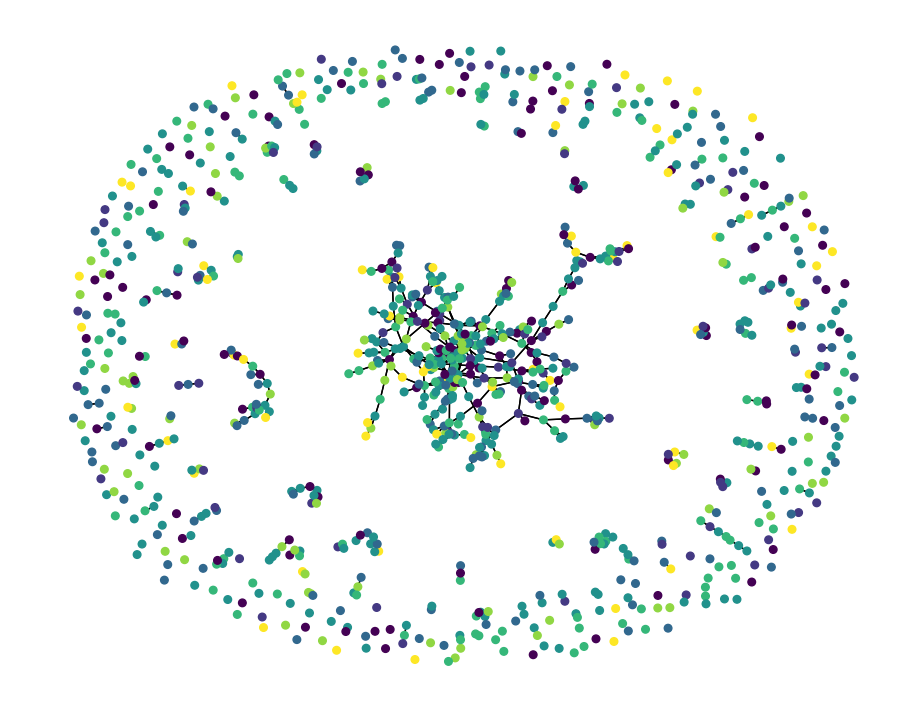

In [9]:
plot_graph(g, y)

In [10]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)

train_data, val_data, test_data = split(graph)

In [11]:
train_data

Data(x=[2708, 1433], edge_index=[2, 8976], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[4488], edge_label_index=[2, 4488])

### 1) Node classification task


Given the Cora dataset, the goal is to build a classification model for the scientific papers classes. More specifically, the model will take the frequency of the words in each article as inputs and the article classes as output.

In [12]:
print("y: ", graph.y.unique())

y:  tensor([0, 1, 2, 3, 4, 5, 6])


In [13]:
print("y classes: ", graph.y.unique())

y classes:  tensor([0, 1, 2, 3, 4, 5, 6])


In [14]:
graph.x.shape

torch.Size([2708, 1433])

In [15]:
print("X: ", graph.x)

X:  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [16]:
import torch.nn as nn
import torch

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dataset.num_node_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, dataset.num_classes)
        )

    def forward(self, data):
        x = data.x
        output = self.layers(x)
        
        return output

In [18]:
def eval_node_classifier(model, graph, mask):
	
	model.eval()
	pred = model(graph).argmax(dim=1)
	correct = (pred[mask] == graph.y[mask]).sum()
	acc = int(correct) / int(mask.sum())
	
	return acc

def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):
	
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 50 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model

In [19]:
device = "cpu"

mlp = MLP().to(device)
optimizer_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
mlp = train_node_classifier(mlp, graph, optimizer_mlp, criterion, n_epochs=500)

test_acc = eval_node_classifier(mlp, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 050, Train Loss: 0.000, Val Acc: 0.456
Epoch: 100, Train Loss: 0.002, Val Acc: 0.518
Epoch: 150, Train Loss: 0.002, Val Acc: 0.526
Epoch: 200, Train Loss: 0.002, Val Acc: 0.532
Epoch: 250, Train Loss: 0.002, Val Acc: 0.536
Epoch: 300, Train Loss: 0.002, Val Acc: 0.538
Epoch: 350, Train Loss: 0.002, Val Acc: 0.538
Epoch: 400, Train Loss: 0.002, Val Acc: 0.534
Epoch: 450, Train Loss: 0.002, Val Acc: 0.534
Epoch: 500, Train Loss: 0.002, Val Acc: 0.536
Test Acc: 0.574


In [20]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [21]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
    
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 050, Train Loss: 0.013, Val Acc: 0.780
Epoch: 100, Train Loss: 0.015, Val Acc: 0.770
Epoch: 150, Train Loss: 0.012, Val Acc: 0.770
Epoch: 200, Train Loss: 0.010, Val Acc: 0.772
Test Acc: 0.813


### 2) Link (edge) prediction task


Given the Cora dataset, the goal is to build a prediction model for the scientific papers citations (links). More specifically, the model will take the frequency of the words in each article as inputs and the link between articles as outputs.

In [22]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

In [23]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)

train_data, val_data, test_data = split(graph)

From the pyG documentation, graph links are represented in coordinate format (COO format). The COO format 

In [24]:
graph.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [25]:
print("y :", train_data.edge_index)

y : tensor([[1224,  598,   53,  ..., 2210, 1940, 2360],
        [2153, 1301, 1358,  ...,  104,  507,  606]])


In [26]:
print("X :", train_data.x)

X : tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [32]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(x=data.x, edge_index=data.edge_index)
    out = model.decode(z=z, edge_label_index=data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

def train_link_predictor(model, train_data, val_data, optimizer, criterion, n_epochs=100):

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(x=train_data.x, edge_index=train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(edge_index=train_data.edge_index,
                                           num_nodes=train_data.num_nodes,
                                           num_neg_samples=train_data.edge_label_index.size(1), 
                                           method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model

In [41]:
train_data.edge_index

tensor([[1224,  598,   53,  ..., 2210, 1940, 2360],
        [2153, 1301, 1358,  ...,  104,  507,  606]])

In [45]:
train_data.edge_label_index

tensor([[1224,  598,   53,  ...,  104,  507,  606],
        [2153, 1301, 1358,  ..., 2210, 1940, 2360]])

In [46]:
neg_edge_index = negative_sampling(edge_index=train_data.edge_index,
                                   num_nodes=train_data.num_nodes,
                                   num_neg_samples=train_data.edge_label_index.size(1), 
                                   method='sparse')

neg_edge_index

tensor([[1526, 2352,  323,  ..., 1702, 2130, 2271],
        [1190,  599, 1644,  ..., 1862, 2215, 2123]])

In [35]:
train_data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model=model,
                             train_data=train_data,
                             val_data=val_data,
                             optimizer=optimizer,
                             criterion=criterion)

test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 0.677, Val AUC: 0.728
Epoch: 020, Train Loss: 0.638, Val AUC: 0.788
Epoch: 030, Train Loss: 0.546, Val AUC: 0.841
Epoch: 040, Train Loss: 0.475, Val AUC: 0.877
Epoch: 050, Train Loss: 0.460, Val AUC: 0.897
Epoch: 060, Train Loss: 0.433, Val AUC: 0.905
Epoch: 070, Train Loss: 0.431, Val AUC: 0.913
Epoch: 080, Train Loss: 0.420, Val AUC: 0.918
Epoch: 090, Train Loss: 0.417, Val AUC: 0.925
Epoch: 100, Train Loss: 0.413, Val AUC: 0.929
Test: 0.925


In [56]:
edge_index_df = pd.DataFrame(train_data.edge_index).T
edge_index_df.columns = ["row", "col"]
edge_index_df["edge"] = 1

edge_index_df.pivot_table(columns=["col"], index=["row"], values=["edge"]).fillna(0)

edge                                               ...                 \
col  0    1    2    3    4    5    6    8    9    10    ... 2697 2698 2699   
row                                                     ...                  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2703  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2704  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2705  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2706  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2707  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

                                         
col  2700 2702 2703 2704 2705 2706 2707  
row                                      
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
2703  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2704  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2705  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2706  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2707  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[2613 rows x 2613 columns]